In [ ]:
import util%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join as pj
from os.path import split as ps
from tifffile import imread
from skimage.restoration import denoise_nl_means, estimate_sigma
from csbdeep.data import Normalizer, PercentileNormalizer

%matplotlib inline

from glob import glob

import re

# Tables

## Consolidate summary csvs

In [133]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*summary.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
    df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False, float_format='%.5f')


outs = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Cosolidate raw csvs

In [128]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*raw.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
#     df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False)


outs = ['tables/planaria_test_data_raw.csv', 'tables/beetle_test_data_raw.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Write RMSE and SSIM wide tables

In [103]:
def _write_wide_tables(df, table_out):
    df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')
    df.columns = df.columns.droplevel()
    df.to_csv(table_out)
    
long = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
df_ls = [pd.read_csv(f) for f in long]
wide = ['tables/planaria_wide.csv', 'tables/beetle_wide.csv']

for df, name in zip(df_ls, wide):
    _write_wide_tables(df, name)


In [104]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df = df.drop('std', axis=1)

outputs = ['planaria-1', 'planaria-3']
_outputs = ['input'] + outputs + ['paper_input', 'paper_network']

df = df[df['output'].isin(_outputs)]

df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')
df.columns = df.columns.droplevel()
df.head()


metric          rmse                                                     ssim  \
output         input paper_input paper_network planaria-1 planaria-3    input   
condition                                                                       
condition_1  0.21048     0.08384       0.03768    0.02868    0.02895  0.11773   
condition_2  0.26055     0.08818       0.03942    0.03607    0.03662  0.08548   
condition_3  0.34852     0.09103       0.04780    0.05468    0.05514  0.05303   

metric                                                       
output      paper_input paper_network planaria-1 planaria-3  
condition                                                    
condition_1     0.21176       0.70774    0.90556    0.90007  
condition_2     0.17071       0.70803    0.84428    0.87815  
condition_3     0.14415       0.60972    0.65758    0.68133

# Plots

## Graphs

In [106]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df.head()

,condition,mean,metric,output,std,study
0,condition_1,0.06538,rmse,beetle-1,0.01124,replication
1,condition_1,0.60107,ssim,beetle-1,0.06290,replication
2,condition_1,0.17660,rmse,nlm,0.04909,replication
3,condition_1,0.29578,ssim,nlm,0.12494,replication
4,condition_1,0.02868,rmse,planaria-1,0.00553,replication


## Using summary

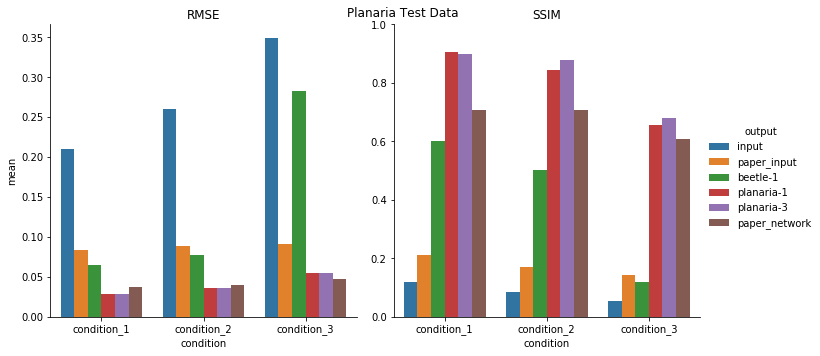

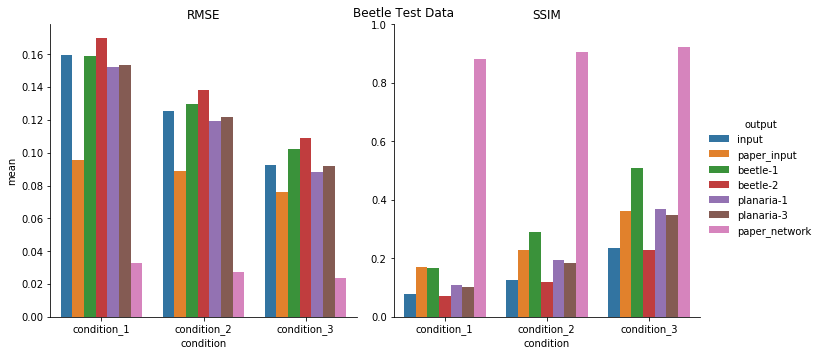

In [145]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
no = ['planaria-4']

df_ls = [df[~df['output'].isin(no)] for df in df_ls]

for df, name in zip(df_ls, ['Planaria Test Data', 'Beetle Test Data']):
    cols = df['output'].unique()
    pop = ['input', 'paper_input']
    cols = [x for x in sorted(cols) if x not in pop + ['nlm', 'paper_network']]
    cols = pop + cols + ['paper_network']


    g = sns.catplot(x='condition', y='mean', hue='output', 
                    kind='bar',
                    col='metric',
                    hue_order=cols,
                    sharey=False, data=df)
    
    g.axes[0,1].set_ylim(0,1)
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)

## Using raw
(+ paper data, so no variance there)

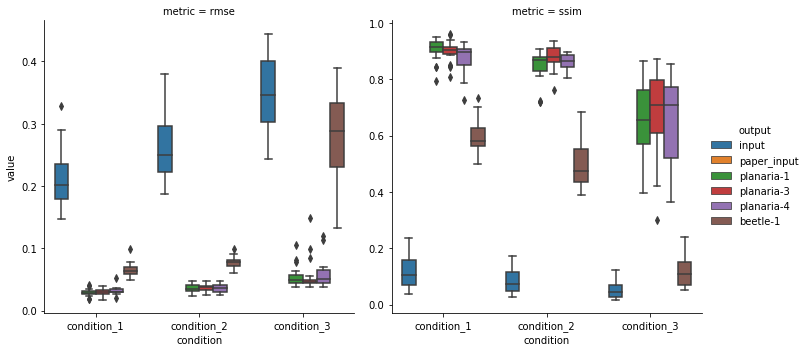

In [129]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_raw.csv',
                                  'tables/beetle_test_data_raw.csv']]
df = df_ls[0]

cols = df['output'].unique()
pop = ['input', 'paper_input']
cols = [x for x in cols if x not in pop + ['nlm']]
cols = pop + cols


g = sns.catplot(x='condition', y='value', hue='output', 
                kind='box',
                col='metric',
                hue_order=cols,
                sharey=False, data=df)
